In [1]:
import os
import random
import sys
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import tensorflow as tf
import pecnet as pc


start = np.datetime64('2001-12-24')  # observed data's time range
end = np.datetime64('2012-12-31')    

DATA_FOLDER = "data/"
STATION_NAMES = ["54_SAK_UNIV_PROB","34_YSL_HVHO_PROB"] 


In [2]:
#This is for getting the same results on every run. 

def reset_random_seeds(seed):
   os.environ['PYTHONHASHSEED']=str(seed)
   tf.random.set_seed(seed)
   np.random.seed(seed)
   random.seed(seed)
   
reset_random_seeds(42)

np.set_printoptions(threshold=sys.maxsize)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [3]:
# reads efd data from .dat files in minute frequency.
# each data 4byte
# start_date is from 2000 till now

def read(station, start, end):
    if isinstance(start, datetime):
        start = np.datetime64(start)
    if isinstance(end, datetime):
        end = np.datetime64(end)

    path = f'{station}_1min.dat'
    with open(path, "rb") as file:
        file.seek(int((start-np.datetime64('2000-01-01'))/np.timedelta64(1, 'm'))*4)
        minutes = int((end-start)/np.timedelta64(1, 'm'))
        data = np.frombuffer(file.read(minutes*4), np.float32)
    times = np.arange(start, end, np.timedelta64(1, 'm'))
    return times, data

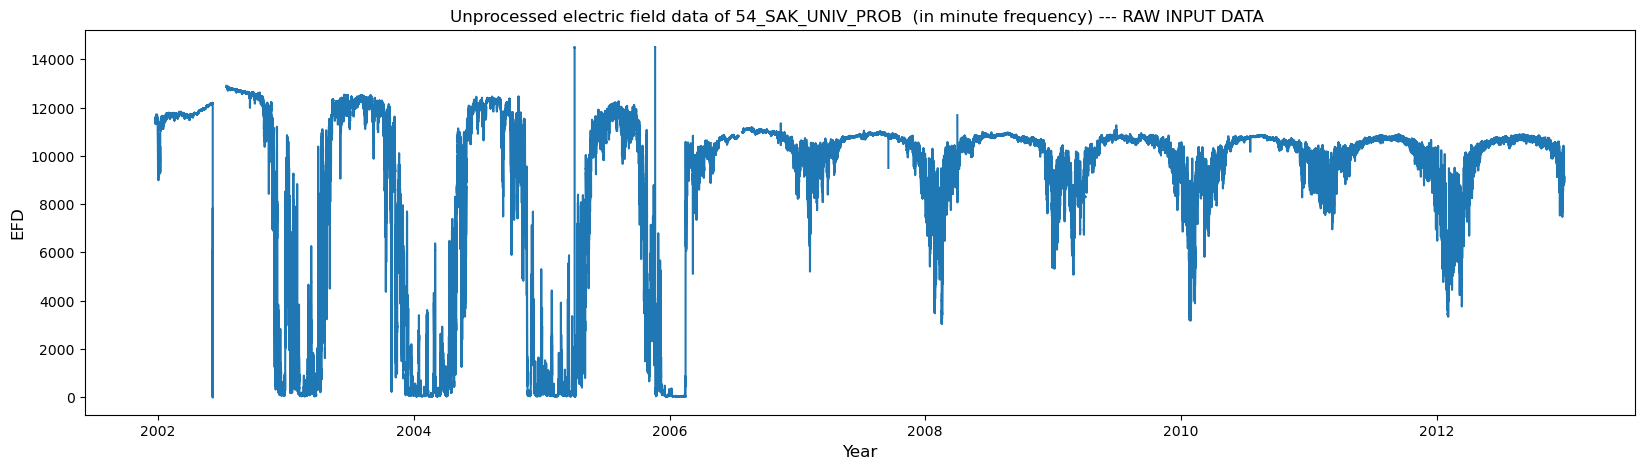

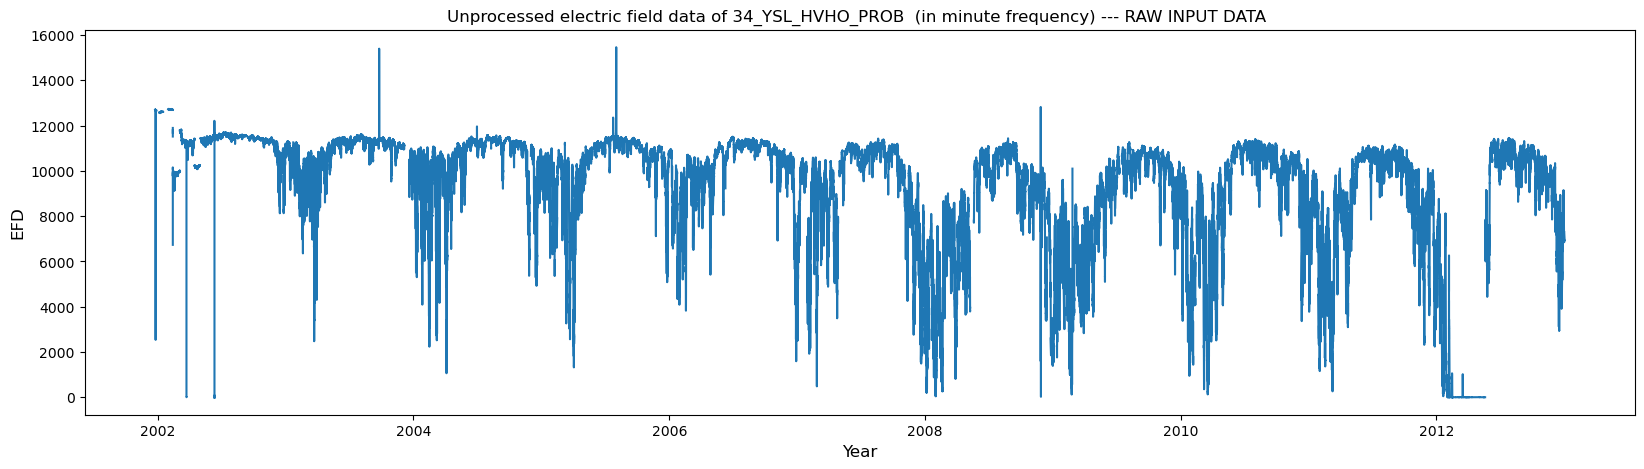

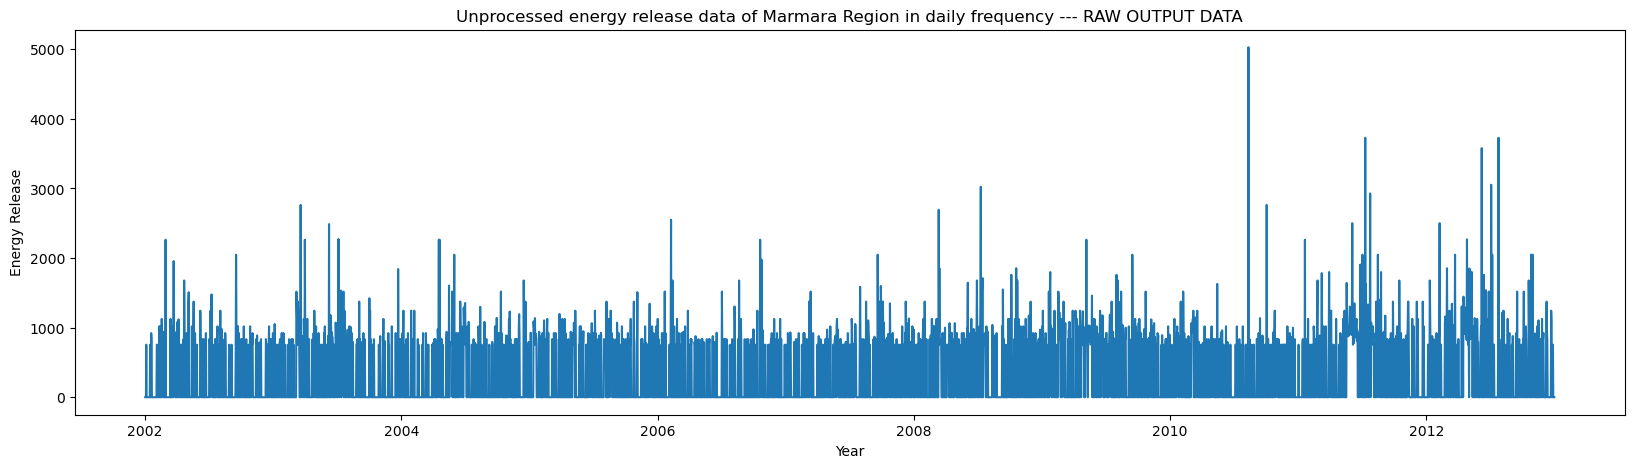

In [4]:
#unprocessed electric field data and energy release data plots (efd=electric field data, er=energy release)

st_efd={}   #entire efd dictionary w.r.t. station codes

for station_name in STATION_NAMES:
    
    timesSignal, dataSignal = read(DATA_FOLDER + station_name, start, end)
    efd = pd.DataFrame({"value":dataSignal}, index=timesSignal)
    st_efd[station_name]=efd
    
    fig,axis=plt.subplots(figsize = (20,5))
    
    axis.set_title("Unprocessed electric field data of "+ station_name + "  (in minute frequency) --- RAW INPUT DATA ",fontsize=12) 
    axis.set_xlabel("Year",fontsize=12)
    axis.set_ylabel("EFD",fontsize=12)
    axis.plot(st_efd[station_name])
    
    fig.savefig("graphs/raw_"+station_name+"_efd.jpg",dpi=500,bbox_inches='tight')


energy_release = pd.read_csv(DATA_FOLDER+"energy_release.csv", index_col=0,parse_dates=[0],dayfirst=True).fillna(0).rename_axis("Date") #between 2002-2013 years 

fig,axis=plt.subplots(figsize=(20,5))

axis.set_xlabel("Year")
axis.set_ylabel("Energy Release")
axis.set_title("Unprocessed energy release data of Marmara Region in daily frequency --- RAW OUTPUT DATA")
axis.plot(energy_release)

fig.savefig("graphs/raw_energy_release_data.jpg",dpi=500,bbox_inches='tight')


In [ ]:
#preprocessing steps for efd & er
#EFD-ENERGY (input-output) dataframe will be generated for each station

df_collection_efd_energy={}
#each value keeps next sevendays' energy release mean.(this day+next six days)
energy_release_weekly = pc.rolling_mean(energy_release["E_daily"].to_numpy().flatten(), 7,False) #last value=2012-12-31


for st_name in st_efd:
    day_group = st_efd[st_name].groupby(pd.Grouper(freq='1d', label='right', closed='right')) # groups 1d. intervals of efd as one elem.
    daily_mean_efd = day_group.mean() # each group 's mean (ignores nan on default) 
    
    #each value keeps eight day mean efd.                               
    eightday_mean_efd = pc.rolling_mean(daily_mean_efd.to_numpy().flatten(),8,False)[:-7] # up to 1 index before the last energy_release date
    
    # In same date index: ER has next seven days mean(date is included) EFD has previous 8 days mean(date is not included) 
    df_collection_efd_energy[st_name]=pd.DataFrame({"EFD":eightday_mean_efd,"ER":energy_release_weekly},index=energy_release.index[:-6]).dropna()

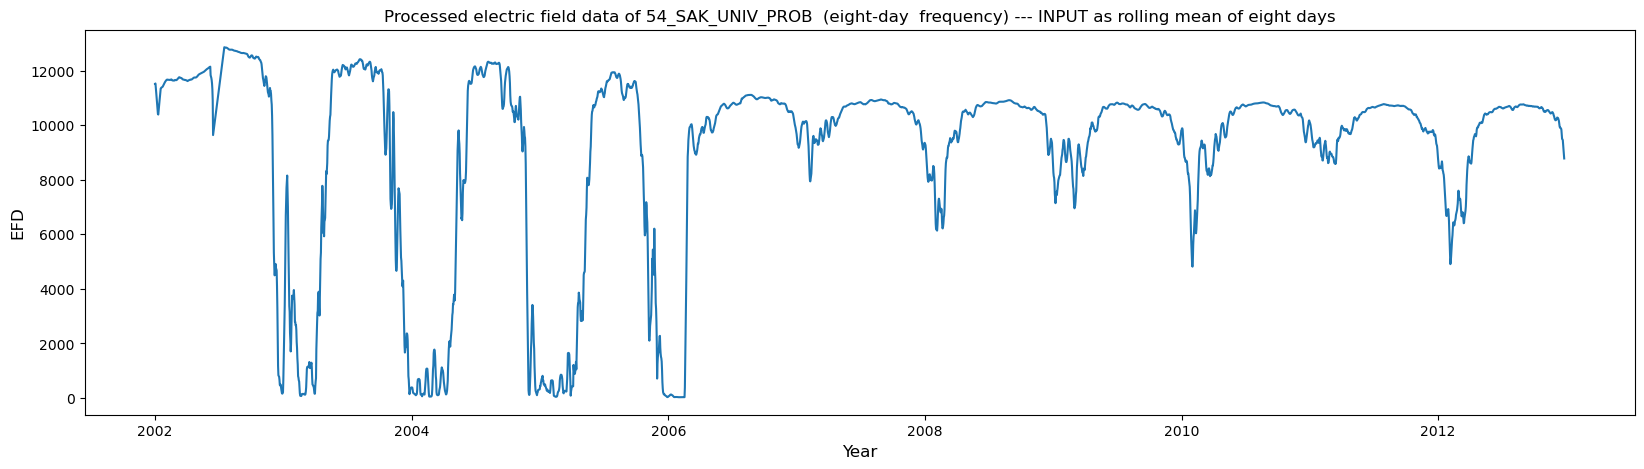

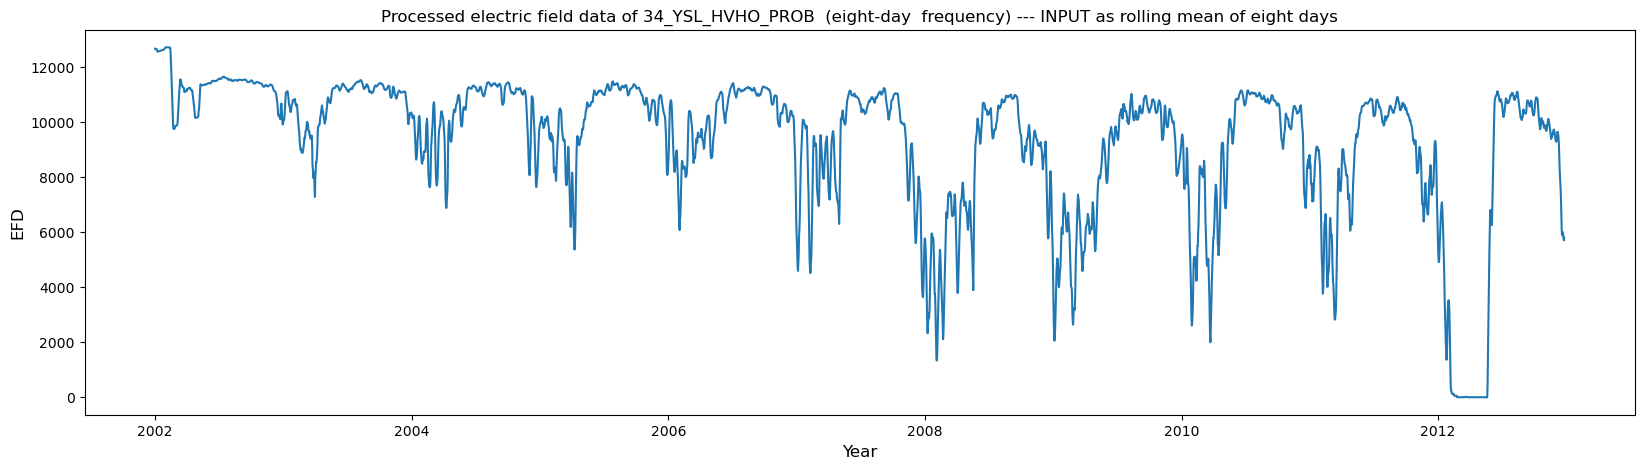

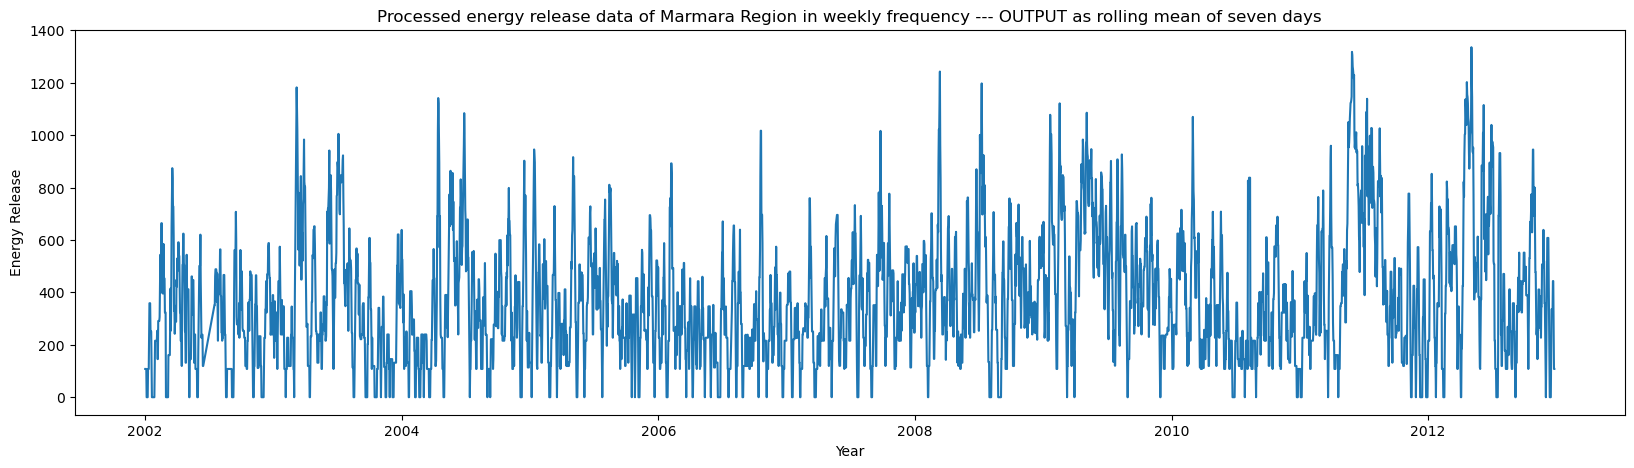

In [6]:
for st_name in df_collection_efd_energy:
    
    fig,axis=plt.subplots(figsize=(20,5))
    axis.set_title("Processed electric field data of "+ st_name + "  (eight-day  frequency) --- INPUT as rolling mean of eight days",fontsize=12) 
    axis.set_xlabel("Year",fontsize=12)
    axis.set_ylabel("EFD",fontsize=12)
    axis.plot(df_collection_efd_energy[st_name]["EFD"])
    fig.savefig("graphs/processed_"+st_name+"_efd.jpg",dpi=500,bbox_inches='tight')
    

fig,axis=plt.subplots(figsize=(20,5))
axis.set_xlabel("Year")
axis.set_ylabel("Energy Release")
axis.set_title("Processed energy release data of Marmara Region in weekly frequency --- OUTPUT as rolling mean of seven days")
axis.plot(df_collection_efd_energy["54_SAK_UNIV_PROB"]["ER"]) #choosed Sak. to show Energy Release Data, any other is nearly same,so station is not important.

fig.savefig("graphs/processed_energy_release_data.jpg",dpi=500,bbox_inches='tight')

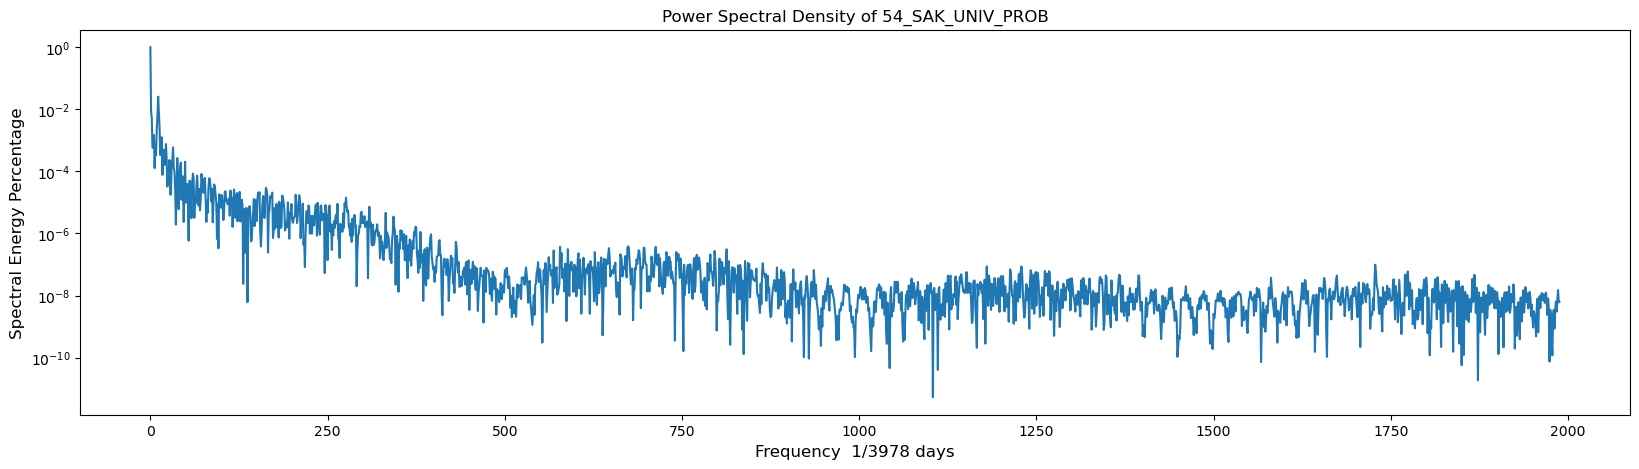

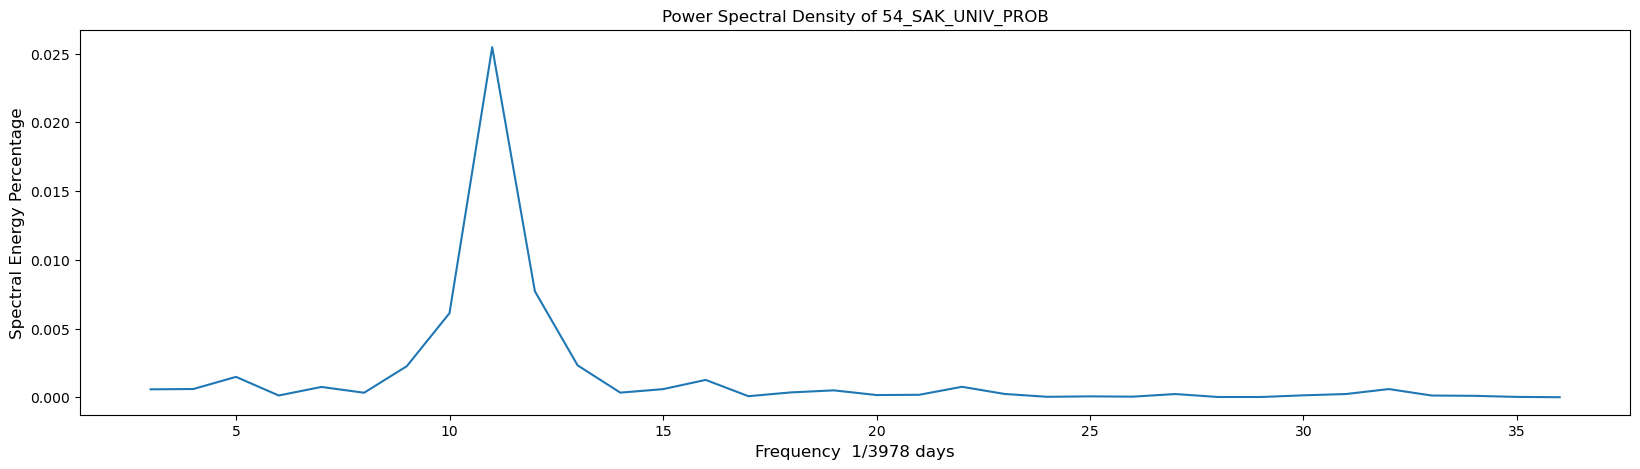

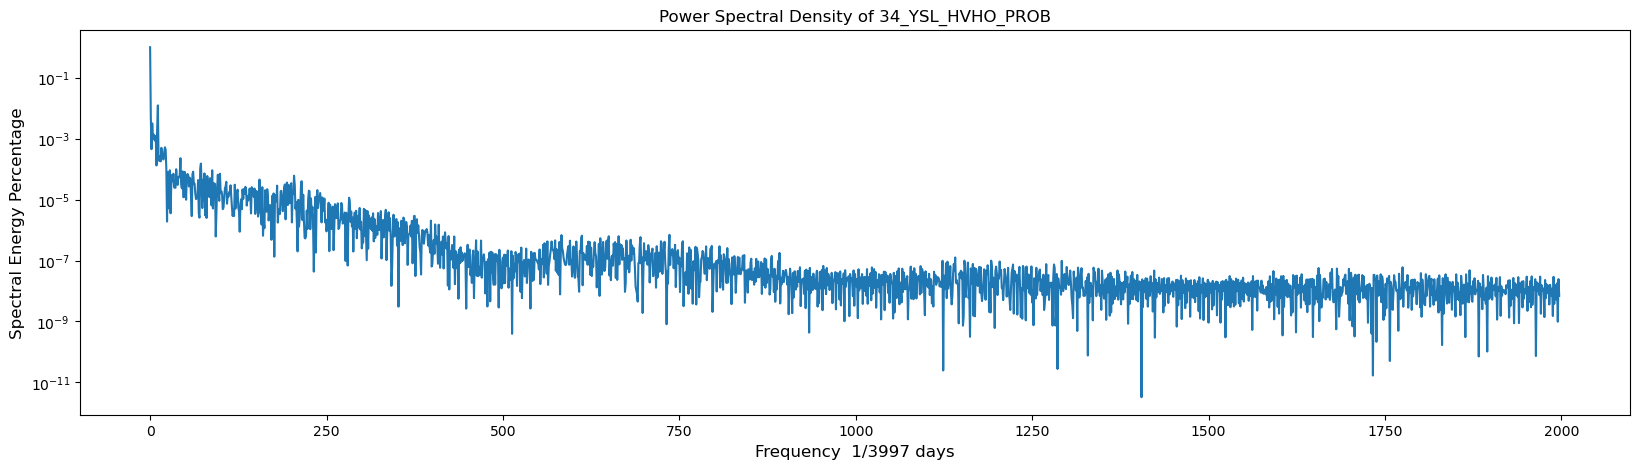

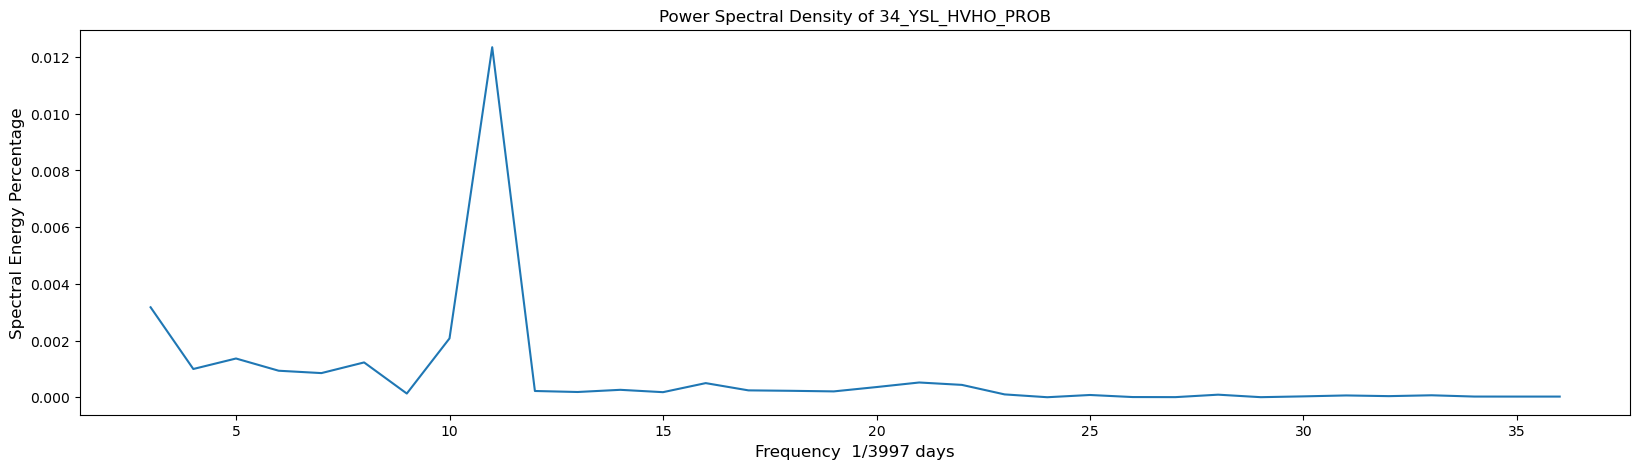

In [7]:
#Power Spectral Density of processed EFD with FFT

for st_name in df_collection_efd_energy:
    
    #apply fft and take absolute values. 3+4j will be 5
    efd_data=df_collection_efd_energy[st_name]["EFD"].to_numpy().flatten()
    fft_efd=abs(np.fft.fft(efd_data))

    #get the list of frequencies
    signal_size=np.size(fft_efd)
    freqs=np.fft.fftfreq(signal_size,d=1/signal_size)

    #remove the conjugate parts of transformation.Because it is symetric and has no new information
    freqs=freqs[:signal_size//2]
    fft_efd=fft_efd[:signal_size//2]

    # get the list of spectrums (normalized with first element of power spectrum) 
    power_spectrum=fft_efd**2
    normalized_power_spectrum=power_spectrum/power_spectrum[0]
    

    fig,axis=plt.subplots(figsize=(20,5))
    plt.title("Power Spectral Density of "+ st_name,fontsize=12) 
    plt.xlabel("Frequency  " +"1/"+str(signal_size)+" days",fontsize=12)
    plt.ylabel("Spectral Energy Percentage",fontsize=12)

    # plot  power spectrum per frequency, with a semilog scale on y
    ordered_indices = np.argsort(freqs)
    axis.semilogy(freqs[ordered_indices], normalized_power_spectrum[ordered_indices])
  
    fig.savefig("graphs/power spectral density_"+st_name+"_efd.jpg",dpi=500,bbox_inches='tight')
    
    fig,axis=plt.subplots(figsize=(20,5))
    plt.title("Power Spectral Density of "+ st_name,fontsize=12) 
    plt.xlabel("Frequency  " +"1/"+str(signal_size)+" days",fontsize=12)
    plt.ylabel("Spectral Energy Percentage",fontsize=12)
    axis.plot(freqs[ordered_indices[3:37]], normalized_power_spectrum[ordered_indices[3:37]])

    fig.savefig("graphs/frequency_yearly"+st_name+"_efd.jpg",dpi=500,bbox_inches='tight') 